# Introduction
This notebook is a simple example of how to read in the mcs_mask.

In [1]:
import xarray as xr
import numpy as np
import intake
import easygems.healpix as egh
import healpy as hp

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append('../src')
import mcs_utils

### Set some variables

In [ ]:
CATALOG = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
LOCATION = "EU"     #Other possibility: 'online', but 'EU' ensures local download
PRODUCT = "icon_d3hp003"

ZOOM = 9
TIME = "PT3H"
ANALYSIS_TIME = (
    np.datetime64("2020-02-01T00:00:00"), np.datetime64("2020-02-15T00:00:00")
    )

# analysis-specific user seetings
TROPICAL_BELT = (-15., 15.)
RADII = np.arange(1.5, 0., -0.1)    # Radius around trigger location in degrees

### Read in simulation data

In [15]:
# Read in simulation data for analysis
cat = intake.open_catalog(CATALOG)[LOCATION]
simu_data = cat[PRODUCT](zoom=ZOOM, time=TIME, chunks="auto").to_dask().\
    pipe(egh.attach_coords)

# Subsample simulation data to relevant time frame
data_field = simu_data.sel(time=slice(*ANALYSIS_TIME))
data_field = data_field.where(
    (data_field['lat'] > TROPICAL_BELT[0]-RADII.max()) &
    (data_field['lat'] < TROPICAL_BELT[1]+RADII.max()), drop=True,
    )

# Get the lat/lon coordinates of the healpix grid
hp_grid = data_field[['lat', 'lon']].compute()

# Get land-sea-mask
if PRODUCT == 'icon_ngc4008':
    ofs = data_field['ocean_fraction_surface']
    ocean_mask = ofs.where(ofs==1).compute()
else:
    ofs = data_field['sftlf']
    land_mask = ofs.where(ofs>0).compute()

    ocean_mask = np.isnan(land_mask)
    ocean_mask = ocean_mask.where(ocean_mask == 1)

/work/mh0731/m300738/conda/envs/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


### Read in and subsample MCS tracking data

In [ ]:
# Read in MCS tracks
mcs_tracks = xr.open_dataset(mcs_utils.MCS_TRACK_FILES[PRODUCT], chunks={})

# Subsample relevant information
mcs_tracks = mcs_tracks[
    ['start_split_cloudnumber', 'start_basetime', 'meanlat', 'meanlon']
    ].compute()

# Subsample MCS tracks to relevant time frame
mcs_tracks = mcs_tracks.where(
    (mcs_tracks['start_basetime'] > ANALYSIS_TIME[0]) &
    (mcs_tracks['start_basetime'] < ANALYSIS_TIME[1]),
    drop=True,
    )

# Select all tracks that don't start as a splitter but are triggered
mcs_tracks_triggered = mcs_tracks.where(
    np.isnan(mcs_tracks["start_split_cloudnumber"]), drop=True,
    )

# Keep only the start location of the tracks
mcs_tracks_triggered['start_lat'] = mcs_tracks_triggered['meanlat'].isel(times=0)
mcs_tracks_triggered['start_lon'] = mcs_tracks_triggered['meanlon'].isel(times=0)
mcs_trigger_locs = mcs_tracks_triggered.drop_vars(
    ['meanlat', 'meanlon', 'start_split_cloudnumber', 'times']
    )

# Select only tropical start locations of MCSs
mcs_trigger_locs = mcs_trigger_locs.where(
    (mcs_trigger_locs['start_lat'] > TROPICAL_BELT[0]) &
    (mcs_trigger_locs['start_lat'] < TROPICAL_BELT[1]),
    drop=True,
    )

# Assign the healpix cell index to each trigger location
mcs_trigger_locs['trigger_idx'] = (
    'tracks',
    hp.ang2pix(
        egh.get_nside(hp_grid),
        mcs_trigger_locs['start_lon'].values,
        mcs_trigger_locs['start_lat'].values,
        nest=True, lonlat=True,
        ),
)

### Determine triggering are of MCS and remove MCSs whose trigger region includes land

In [10]:
# Select increasingly smaller circular region around trigger location
mcs_trigger_locs = mcs_utils.add_circular_trigger_areas(
    mcs_trigger_locs, RADII, hp_grid
    )

# Generate mask of MCS tracks with triggering region entirely over ocean
mcs_trigger_locs_ocean = mcs_utils.remove_land_triggers(
    mcs_trigger_locs, ocean_mask
    )

### Plot trigger locations in tropics

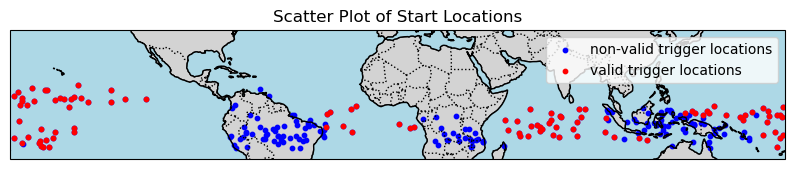

In [11]:
# Create a figure and axis with a map projection
fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6)
    )

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot the scatter points
ax.scatter(
    mcs_trigger_locs['start_lon'], mcs_trigger_locs['start_lat'], 
    s=10, c='blue', transform=ccrs.PlateCarree(),
    label='non-valid trigger locations',
    )
ax.scatter(
    mcs_trigger_locs_ocean['start_lon'], mcs_trigger_locs_ocean['start_lat'], 
    s=10, c='red', transform=ccrs.PlateCarree(),
    label='valid trigger locations',
    )

# Add labels and legend
ax.set_title('Scatter Plot of Start Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_extent([-180, 180, -20, 40], crs=ccrs.PlateCarree())
ax.legend(loc='upper right')

plt.show()

### Plot trigger locations with largest circular trigger area in exemplary region

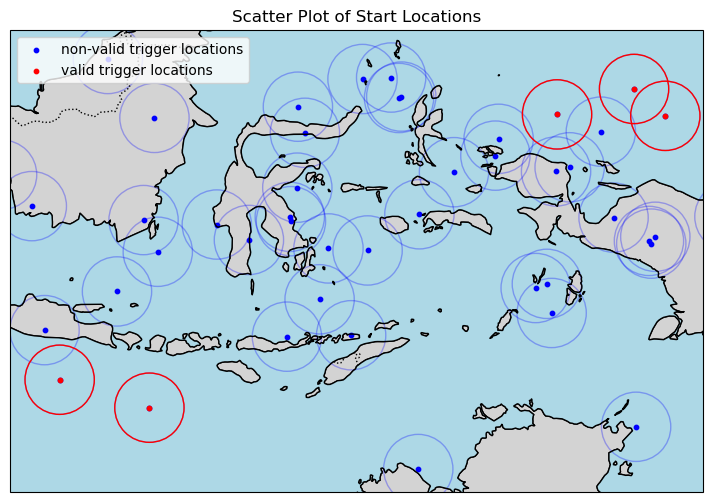

In [12]:
# Create a figure and axis with a map projection
fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6)
    )

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot non-valid points
ax.scatter(
    mcs_trigger_locs['start_lon'], mcs_trigger_locs['start_lat'], 
    s=10, c='blue', transform=ccrs.PlateCarree(),
    label='non-valid trigger locations',
    )
for lon, lat in zip(
    mcs_trigger_locs['start_lon'].values, mcs_trigger_locs['start_lat'].values
    ):
    circle = Circle(
        (lon, lat), radius=RADII.max(), transform=ccrs.PlateCarree(),
        color='blue', alpha=0.3, fill=False
    )
    ax.add_patch(circle)

# Plot valid points
ax.scatter(
    mcs_trigger_locs_ocean['start_lon'], mcs_trigger_locs_ocean['start_lat'], 
    s=10, c='red', transform=ccrs.PlateCarree(),
    label='valid trigger locations',
    )
for lon, lat in zip(
    mcs_trigger_locs_ocean['start_lon'].values,
    mcs_trigger_locs_ocean['start_lat'].values
    ):
    circle = Circle(
        (lon, lat), radius=RADII.max(), 
        transform=ccrs.PlateCarree(), color='red', alpha=1, fill=False
    )
    ax.add_patch(circle)

# Add labels and legend
ax.set_title('Scatter Plot of Start Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_extent([110, 140, -15, 5], crs=ccrs.PlateCarree())
ax.legend(loc='upper left')

plt.show()